# 1. Imports and Setup
Handles the pathing so we can import our `src` module from the parent directory

In [ ]:
import os
import sys
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import random

# Add project root to path so we can import 'src'
# Assumes notebook is running from 'pneumonia-detection-modular/notebooks/'
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.model import CheXDS
from src.config import DEVICE, MODEL_SAVE_PATH, IMG_SIZE, TEST_DIR

print(f"Project Environment Setup Complete")
print(f"Project Root: {project_root}")
print(f"Using Device: {DEVICE}")

Project Environment Setup Complete
Using Device: cpu


# 2. Load the Trained Model
This loads the CheX-DS model (best model) from the `models/` folder.

In [27]:
# Initialize the CheX-DS Architecture
model = CheXDS(num_classes=2)

# Load Weights
weights_path = os.path.join(project_root, 'models', 'pneumonia_model.pth')
if not os.path.exists(weights_path):
    print("Error: Model weights not found. Please train the model first.")
else:
    state_dict = torch.load(weights_path, map_location=DEVICE, weights_only=True)
    model.load_state_dict(state_dict)
    model.to(DEVICE)
    model.eval()
    print("CheX-DS Model Loaded Successfully")

CheX-DS Model Loaded Successfully


# 3. Define Inference Function
A helper function to process and predict on a single image.

In [28]:
def predict_image(image_path):
    # Preprocessing (Must match training config)
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Error: {e}")
        return None, None, 0.0

    # Add batch dimension [1, 3, 256, 256]
    input_tensor = transform(image).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confidence, pred_idx = torch.max(probs, 1)
        
    label = ['NORMAL', 'PNEUMONIA'][pred_idx.item()]
    return image, label, confidence.item()

# 4. Run Interactive Demo
Run this cell repeatedly to test random images from the test set.

Image 1: IM-0085-0001.jpeg
  Ground Truth: NORMAL | Prediction: NORMAL | Confidence: 78.82%
  Result: ✓ Correct

Image 2: person3_virus_17.jpeg
  Ground Truth: PNEUMONIA | Prediction: NORMAL | Confidence: 64.45%
  Result: ✗ Incorrect

Image 3: person100_bacteria_481.jpeg
  Ground Truth: PNEUMONIA | Prediction: PNEUMONIA | Confidence: 99.88%
  Result: ✓ Correct

Image 4: person158_bacteria_742.jpeg
  Ground Truth: PNEUMONIA | Prediction: PNEUMONIA | Confidence: 97.93%
  Result: ✓ Correct



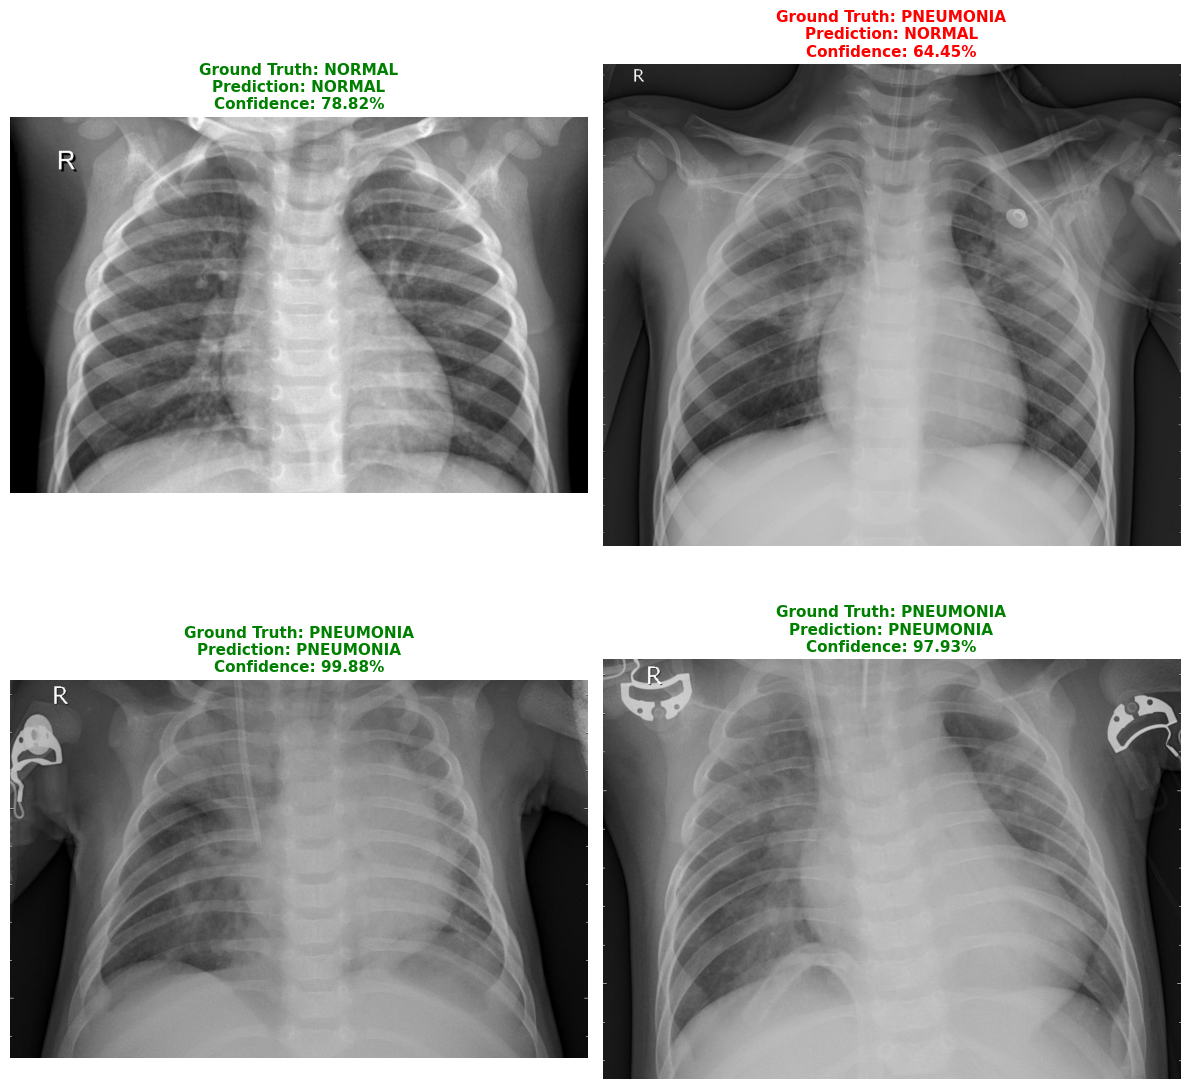

In [32]:
# Select and display 4 random images from the Test Set in a 2x2 grid
if os.path.exists(TEST_DIR):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.ravel()
    
    for idx in range(4):
        # Randomly select class and image
        target_class = random.choice(['NORMAL', 'PNEUMONIA'])
        class_dir = os.path.join(TEST_DIR, target_class)
        
        filename = random.choice(os.listdir(class_dir))
        full_path = os.path.join(class_dir, filename)
        
        # Predict
        img, pred, conf = predict_image(full_path)
        
        # Visualize
        axes[idx].imshow(img, cmap='gray')
        
        # Set color based on correct/incorrect prediction
        color = 'green' if pred == target_class else 'red'
        
        # Create title with prediction info
        title = f"Ground Truth: {target_class}\nPrediction: {pred}\nConfidence: {conf*100:.2f}%"
        axes[idx].set_title(title, color=color, fontsize=11, fontweight='bold')
        axes[idx].axis('off')
        
        # Print details for each image
        print(f"Image {idx+1}: {filename}")
        print(f"  Ground Truth: {target_class} | Prediction: {pred} | Confidence: {conf*100:.2f}%")
        print(f"  Result: {'✓ Correct' if pred == target_class else '✗ Incorrect'}\n")
    
    plt.tight_layout()
    plt.show()
else:
    print("Test data not found. Please run download_data.py first.")